## Time Series Regression


In [42]:
# version 1.0
source("https://raw.githubusercontent.com/eogasawara/mylibrary/master/myTSRegression.R")

## Dataset for exploring
Some parameters are fixed but can be explored. 
TSNormalization used is ts_gminmax(), but other normalizations are available.

In [43]:
load_series <- function(name) {
  link <- url(sprintf("https://raw.githubusercontent.com/eogasawara/mylibrary/master/data/time-series/%s.RData", name))
  x <- get(load(link))
  return(x)  
}
x <- load_series("sin")
sahead <- 1
tsize <- 1
swsize <- 10
preproc <- ts_gminmax()


## General function for testing regression methods

In [44]:
train_test <- function(x, model, sw, test_size, steps_ahead) {
  ts <- ts_data(x, sw)
  
  samp <- ts_sample(ts, test_size)

  io_train <- ts_projection(samp$train)

  model <- prepare(model, x=io_train$input, y=io_train$output)
  
  adjust <- action(model, io_train$input)
  ev_adjust <- tsregression_evaluation(io_train$output, adjust)
  print(head(ev_adjust$metrics))

  io_test <- ts_projection(samp$test)
  
  prediction <- action(model, io_test$input)
  ev_prediction <- tsregression_evaluation(io_test$output, prediction)
  print(head(ev_prediction$metrics))
  
  print(sprintf("%s %.2f", class(model)[1], 100*ev_prediction$metrics$smape))
  
  plot(model, y=c(io_train$output, io_test$output), yadj=adjust, ypre=prediction)
  
  return(model)
}


## ARIMA (baseline)

tsreg_arima,prepare.tsreg_arima,0.006,



        mse      smape
1 0.0123684 0.05188252
        mse      smape
1 0.0257263 0.08558225
[1] "tsreg_arima 8.56"


$log_time
[1] 0.006076332

$mdl
Series: x 
ARIMA(1,0,0) with non-zero mean 

Coefficients:
         ar1    mean
      0.9807  2.0922
s.e.  0.0138  0.4076

sigma^2 estimated as 0.01262:  log likelihood=75.33
AIC=-144.65   AICc=-144.4   BIC=-136.87

$log_msg
[1] "tsreg_arima,prepare.tsreg_arima,0.006,"

attr(,"class")
[1] "tsreg_arima"   "tsregression"  "dal_transform"

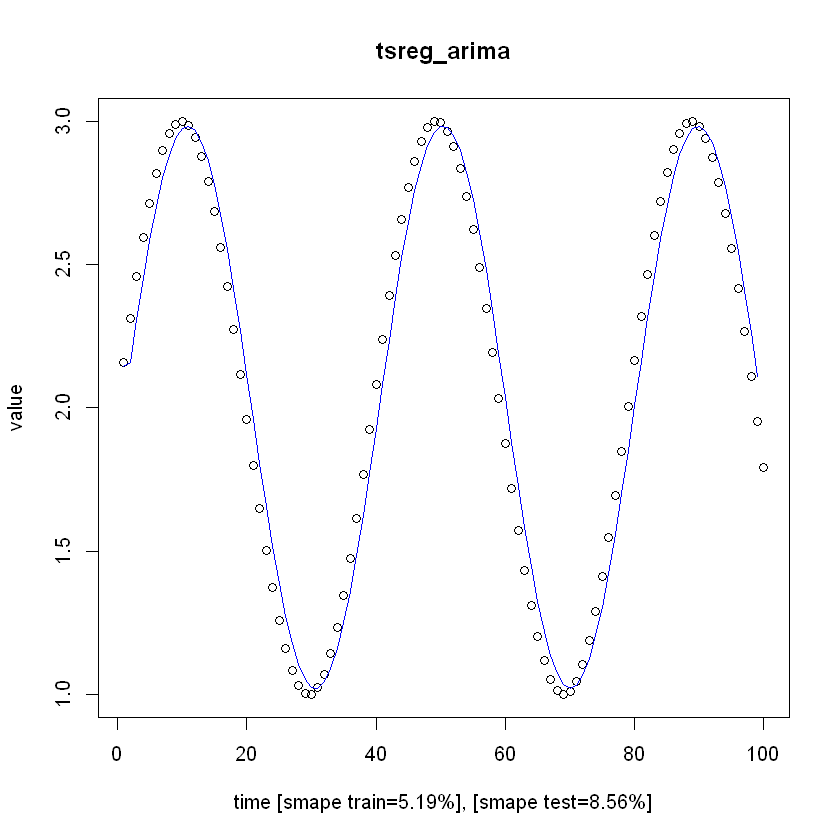

In [45]:
train_test(x, model=tsreg_arima(), 0, test_size = tsize, steps_ahead = sahead)

## Neural Networks - MLP

tsreg_mlp,prepare.tsreg_sw,0.003,



          mse      smape
1 0.002790585 0.02494837
          mse      smape
1 0.006242033 0.04309153
[1] "tsreg_mlp 4.31"


$preprocess
$gmin
[1] 1.000096

$gmax
[1] 2.999785

attr(,"class")
[1] "ts_gminmax"    "ts_normalize"  "normalize"     "dal_transform"

$input_size
[1] 4

$neurons
[1] 5

$decay
[1] 0.08

$maxit
[1] 1000

$log_time
[1] 0.002517116

$mdl
a 4-5-1 network with 31 weights
options were - linear output units  decay=0.08

$log_msg
[1] "tsreg_mlp,prepare.tsreg_sw,0.003,"

attr(,"class")
[1] "tsreg_mlp"     "tsreg_sw"      "tsregression"  "dal_transform"

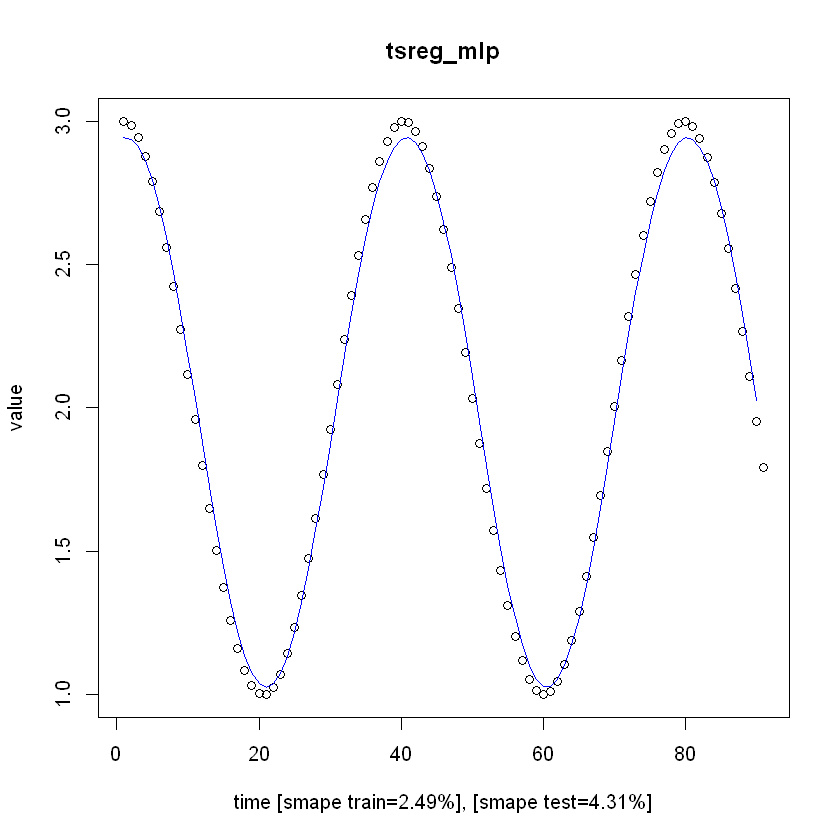

In [46]:
#do not set neurons and decay for automatic hyperparameter optimization
train_test(x, model=tsreg_mlp(preproc, input_size=4, neurons=5, decay=0.08), sw = swsize, test_size = tsize, steps_ahead = sahead)

## SVM


In [ ]:
#do not set epsilon and cost for automatic hyperparameter optimization
train_test(x, model=tsreg_svm(preproc, input_size=4, epsilon=0.1, cost=20.000), sw = swsize, test_size = tsize, steps_ahead = sahead)

## Random Forest

In [ ]:
#do not set mtry and ntree for automatic hyperparameter optimization
train_test(x, model=tsreg_rf(preproc, input_size=4, mtry=5, ntree=375), sw = swsize, test_size = tsize, steps_ahead = sahead)

## ELM

In [ ]:
train_test(x, model=tsreg_elm(preproc, input_size=4), sw = swsize, test_size = tsize, steps_ahead = sahead)

## Convolutional neural networks (CNN)

In [ ]:
train_test(x, model=tsreg_cnn(preproc, input_size=4, epochs = 100), sw = swsize, test_size = tsize, steps_ahead = sahead)

## Long short-term memory (LSTM)

In [ ]:
train_test(x, model=tsreg_lstm(preproc, input_size=4, epochs = 100), sw = swsize, test_size = tsize, steps_ahead = sahead)